In [1]:
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,SimpleRNN,Input
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data=pd.read_csv("training.1600000.processed.noemoticon.csv",encoding='latin',header=None)
data.head(8000001)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
data.columns=['sentiment','id','date','quary','user','text']
data.head()

,sentiment,id,date,quary,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data=data.drop(['id','date','quary','user'],axis=1)


In [5]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
label_sentiment={0:"Negative",4:"Postive"}
def label_decoder(label):
    return label_sentiment[label]
data.sentiment=data.sentiment.apply(lambda x:label_decoder(x))
data.head(100)

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
95,Negative,Strider is a sick little puppy http://apps.fa...
96,Negative,"so rylee,grace...wana go steve's party or not?..."
97,Negative,"hey, I actually won one of my bracket pools! T..."
98,Negative,"@stark YOU don't follow me, either and i work..."


In [7]:
data.head(800001)

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
799996,Negative,Gmail is down?
799997,Negative,rest in peace Farrah! So sad
799998,Negative,@Eric_Urbane Sounds like a rival is flagging y...
799999,Negative,has to resit exams over summer... wishes he w...


In [8]:
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def process(text,stem=False):
    text=re.sub(text_cleaning_re,' ',str(text).lower()).strip()
    tokens=[]
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [10]:
data.text=data.text.apply(lambda x: process(x))

In [11]:
data.text

0               awww bummer shoulda got david carr third day
1          upset update facebook texting might cry result...
2          dived many times ball managed save 50 rest go ...
3                           whole body feels itchy like fire
4                                           behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996             thewdb com cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1600000, dtype: object

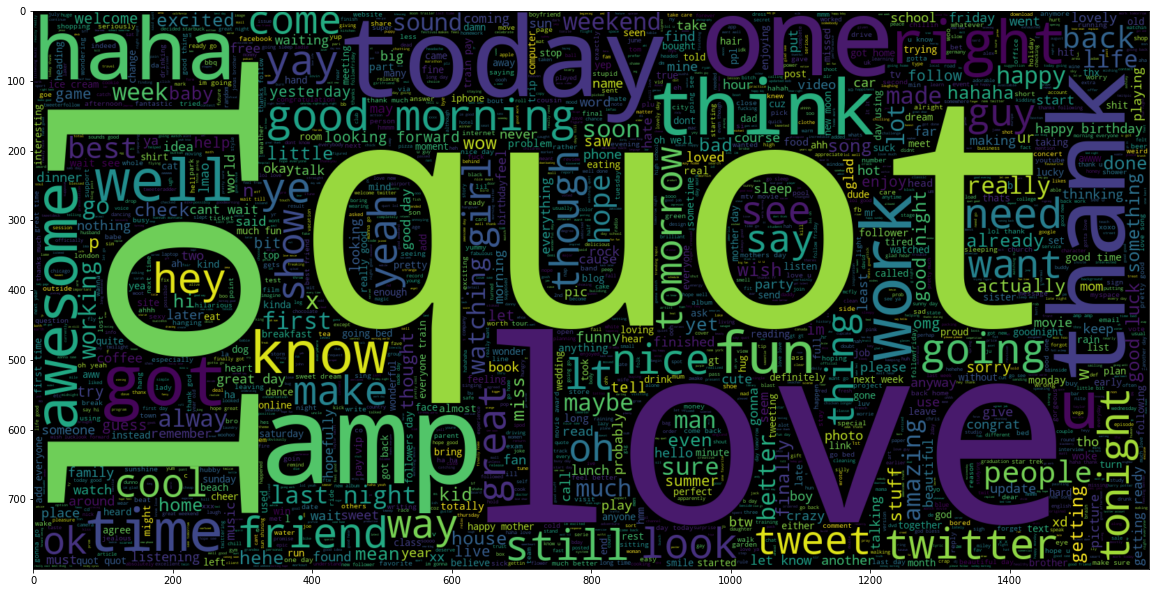

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 'Postive'].text))
plt.imshow(wc , interpolation = 'bilinear')

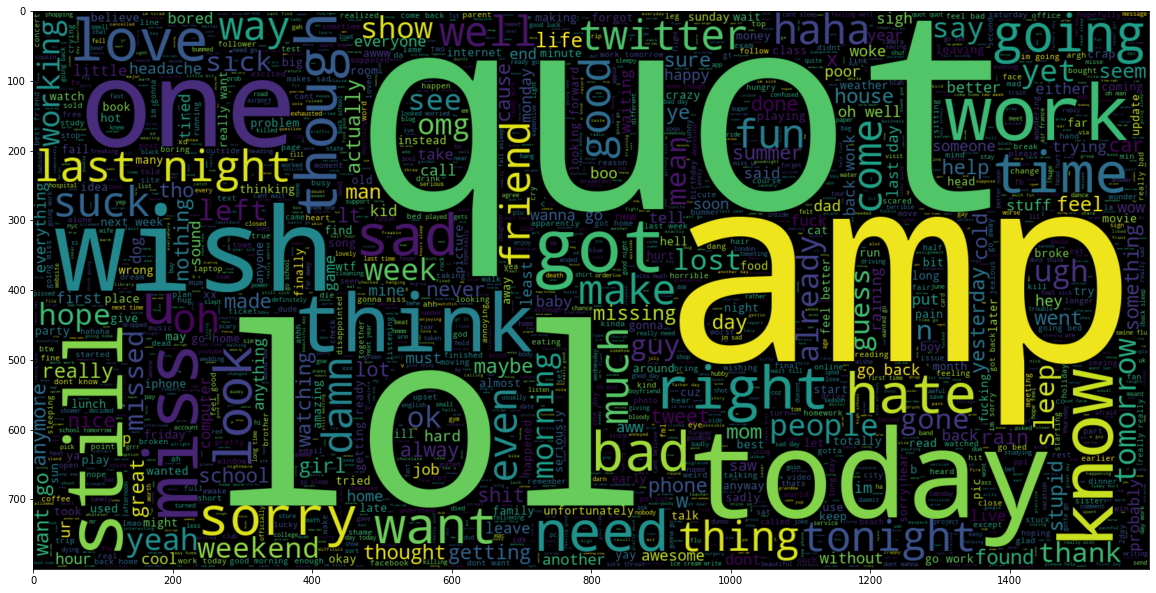

In [13]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')


In [14]:
train_data, test_data = train_test_split(data, test_size=1-0.8,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [15]:
toknizer=Tokenizer()
toknizer.fit_on_texts(train_data.text)
word_index=toknizer.word_index
vocab_size=len(toknizer.word_index)+1


In [29]:
x_train=pad_sequences(toknizer.texts_to_sequences(train_data.text),maxlen=30)
x_test=pad_sequences(toknizer.texts_to_sequences(test_data.text),maxlen=30)

x_train.shape

(1280000, 30)

In [17]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [24]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
vocab_size=100000
MAX_SEQUENCE_LENGTH=30

In [26]:
model = Sequential()
model.add(Embedding(vocab_size,EMBEDDING_DIM ))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(6,activation='softmax' ))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         30000000  
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 3606      
                                                                 
Total params: 31,446,006
Trainable params: 31,446,006
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)